In [1]:
import pdf
import util
import os
import chunking
import vector_store as vs
from tqdm import tqdm
from langchain_qdrant import FastEmbedSparse
from langchain_openai import OpenAIEmbeddings
import api
import retrieval
import chatbot
import re
from IPython.display import Image, display
import evaluation as eval

/Users/lucachangretta/opt/anaconda3/envs/Thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

pdf_paths = ["Dataset/File1_manual.pdf", "Dataset/File2_manual.pdf", "Dataset/File3_manual.pdf", "Dataset/File4_manual.pdf"]
query_path = "query.txt"

individual_pages_folder = 'manual_individual_pages'
all_contents_folder = 'manual_all_contents'

text_collection_name = 'manual_texts'
caption_collection_name = 'manual_captions'

disease_predictions_path = 'manual_evaluation_results/disease_predictions.json'
image_predictions_path = 'manual_evaluation_results/image_predictions.json'
contexts_path = 'manual_evaluation_results/retrieved_contexts.json'

eval_result_path = 'manual_evaluation_results/score.json'
eval_record_path = 'manual_evaluation_results/record.json'

# Extract Content

In [3]:
util.clear_folder(individual_pages_folder)
util.clear_folder(all_contents_folder)

for pdf_path in pdf_paths:
    file = pdf.PDF(pdf_path)
    file.extract_pages()
    all_texts = file.combine_pages_txt()

    # Extract single pages
    image_save_dir = f"{all_contents_folder}/{file.name}/Images"
    os.makedirs(image_save_dir, exist_ok=True)
    for page in file.pages:
        page_text_save_dir = f"{individual_pages_folder}/{file.name}"
        os.makedirs(page_text_save_dir, exist_ok=True)
        util.save_text_to_file(page.text, f"{page_text_save_dir}/Page{page.page_num+1}.txt")
        for image in page.images:
            image_save_path = f"{image_save_dir}/Page{image.parent_page_num+1}_Figure{image.index+1}.{image.ext}"
            image.save(image_save_path)
            image.path = image_save_path

    # Save combined texts
    all_texts_save_dir = f"{all_contents_folder}/{file.name}"
    os.makedirs(all_texts_save_dir , exist_ok=True)
    util.save_text_to_file(all_texts, f"{all_texts_save_dir}/{file.name}.txt")

    # Save all the images info
    images_info_save_dir = f"{all_contents_folder}/{file.name}"
    os.makedirs(images_info_save_dir, exist_ok=True)
    file.save_images_info(f"{images_info_save_dir}/Images_info.json")


manual_individual_pages is ready for new content.
manual_all_contents is cleared!
manual_all_contents is ready for new content.


Processing pages of file Dataset/File1_manual.pdf: 100%|██████████| 2/2 [00:00<00:00, 86.61it/s]


Saved content to manual_all_contents/File1_manual/Images_info.json


Processing pages of file Dataset/File2_manual.pdf: 100%|██████████| 16/16 [00:00<00:00, 140.67it/s]


Saved content to manual_all_contents/File2_manual/Images_info.json


Processing pages of file Dataset/File3_manual.pdf: 100%|██████████| 59/59 [00:00<00:00, 631.90it/s]


Saved content to manual_all_contents/File3_manual/Images_info.json


Processing pages of file Dataset/File4_manual.pdf: 100%|██████████| 23/23 [00:00<00:00, 660.22it/s]

Saved content to manual_all_contents/File4_manual/Images_info.json


# Pair Captions

In [4]:
for pdf_path in pdf_paths:
    file = pdf.PDF(pdf_path)
    file.images = util.create_class_from_json(pdf.Image, f"{all_contents_folder}/{file.name}/Images_info.json")
    for image in file.images:
        txt_path = f"{individual_pages_folder}/{file.name}/Page{image.parent_page_num+1}.txt"
        image.pair_caption(txt_path)

    images_info_save_dir = f"{all_contents_folder}/{file.name}"
    os.makedirs(images_info_save_dir, exist_ok=True)
    file.save_images_info(f"{images_info_save_dir}/Images_info.json")

Saved content to manual_all_contents/File1_manual/Images_info.json
Saved content to manual_all_contents/File2_manual/Images_info.json
Saved content to manual_all_contents/File3_manual/Images_info.json
Saved content to manual_all_contents/File4_manual/Images_info.json


# Generate & Save Embeddings

In [5]:
chunks = []
images = []

for pdf_path in pdf_paths:
    file = pdf.PDF(pdf_path)
    file.images = util.create_class_from_json(pdf.Image, f"{all_contents_folder}/{file.name}/Images_info.json")
    
    splits = chunking.single_page_chunk(f"{individual_pages_folder}/{file.name}")
    for split in splits:
        chunks.append(chunking.Chunk(split))

    for image in file.images:
        images.append(image)

vs.create_collection(text_collection_name, 1536)
vs.create_collection(caption_collection_name, 1536)

for chunk in tqdm(chunks, desc="Adding text cunks to the vectore store."):
    vs.add_txt(text_collection_name, chunk)
for image in tqdm(images, desc="Adding captions to the vectore store."):
    vs.add_image(caption_collection_name, image)

Deleted old version collection manual_texts
Collection manual_texts initialized.
Deleted old version collection manual_captions
Collection manual_captions initialized.


Adding captions to the vectore store.: 100%|██████████| 97/97 [04:46<00:00,  2.96s/it]


# Respond to a Query

In [3]:
def respond(
        query, 
        text_collection_name, 
        caption_collection_name, 
        txt_similarity_topk, 
        image_similarity_topk, 
        cos_filtering_threshold, 
        cos_filtering_topk,
        verbose=1):
    
    dense_embedding_function = OpenAIEmbeddings(api_key=api.OPENAI_KEY, model="text-embedding-3-small")
    sparse_embedding_function = FastEmbedSparse(model_name="prithivida/Splade_PP_en_v1")
    
    collection_text = vs.get_collection(
        text_collection_name, 
        dense_embedding_function,
        sparse_embedding_function
    )

    collection_caption = vs.get_collection(
        caption_collection_name, 
        dense_embedding_function,
        sparse_embedding_function
    )

    text_retriever = retrieval.Retriever(query, collection_text)
    text_retriever.similarity_search(txt_similarity_topk)
    text_retriever.rerank('content')
    text_retriever.cos_filtering(vs.dense_embed, 'content', cos_filtering_threshold, cos_filtering_topk)

    context = " "
    for filtered_context in text_retriever.filtered_contexts:
        context += filtered_context
    
    response = chatbot.disease_list_prediction(query, context)
    pattern = r'(Disease name \d+:\s*.*?)(?=Disease name \d+:|$)'
    predictions = re.findall(pattern, response, flags=re.DOTALL)

    image_paths = []
    for prediction in predictions:
        image_retriever = retrieval.Retriever(prediction, collection_caption)
        image_retriever.similarity_search(image_similarity_topk)
        image_retriever.rerank('caption')
        retrieved_image = image_retriever.reranked_docs[0]
        image_payload = vs.retrieve_payload(retrieved_image, collection_caption)
        image_path = image_payload["path"]
        image_paths.append(image_path)
        if verbose:
            print(prediction)
            display(Image(filename=image_path))

    return predictions, image_paths, context

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Disease name 1: Ameloblastoma  
Disease 1 description: Ameloblastoma is a benign, but locally aggressive odontogenic tumor commonly occurring in the posterior mandible but can also present in the maxilla. It is known for causing expansion, tooth displacement, and sometimes root resorption. Ameloblastomas are typically multilocular, but can present as unilocular radiolucencies as well, especially in older patients.  




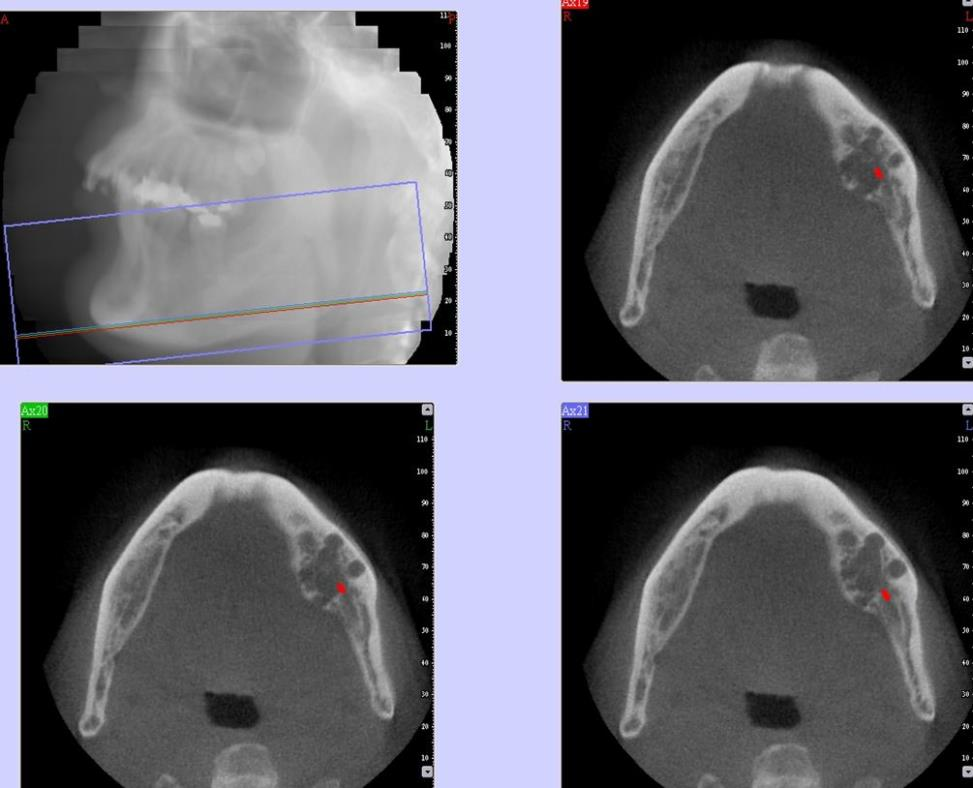

Searching for the closest document.
Reranking
Disease name 2: Odontogenic Keratocyst  
Disease 2 description: Odontogenic keratocyst is an aggressive cyst characterized by its keratinized epithelial lining, typically occurring in the posterior mandible, but can be found in the maxilla as well. It is often unilocular in its initial phases and exhibits corticated borders. There is a potential for root resorption and tooth displacement, and it often involves the crown of a tooth, as apparent in its association with unerupted or impacted teeth.




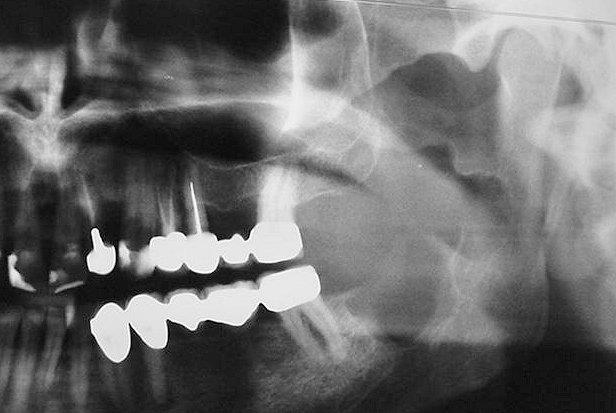

Searching for the closest document.
Reranking
Disease name 3: Dentigerous (follicular) cyst  
Disease 3 description: A dentigerous cyst is a common odontogenic cyst that arises around the crown of an unerupted or developing tooth, often affecting the mandibular third molars or maxillary canines. It is typically a unilocular radiolucency with corticated borders, and it may cause tooth displacement or impaction. Root resorption can also occur, although less commonly.


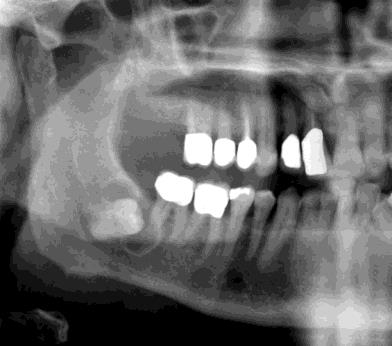

In [7]:
query = util.read_query(query_path).replace('\n', "")
predictions, image_paths, context = respond(query, text_collection_name, caption_collection_name, 10, 5, 0.8, 3)

# Evaluation

In [4]:
def evaluation(qa_pairs, 
               symptom_predictions_path, 
               image_predictions_path, 
               contexts_path, 
               text_collection_name, 
               caption_collection_name, 
               txt_similarity_topk, 
               image_similarity_topk, 
               cos_filtering_threshold, 
               cos_filtering_topk,
               eval_result_path,
               eval_record_path,
               sparse_sim_threshold
               ):
    
    truths = []
    queries = []
    for pair in qa_pairs:
        truths.append(pair['answer'])
        queries.append(pair['query'])

    if not os.path.exists(symptom_predictions_path) or not  os.path.exists(image_predictions_path) or not os.path.exists(contexts_path):
        print("Generating responses.")
        symptom_predictions = []
        image_predictions = []
        contexts = []
        
        for query in tqdm(queries):
            cleaned_query = query.replace('\n', "")
            cleaned_query = cleaned_query.strip()
            symptom_prediction, image_prediction, context = respond(
                                                                cleaned_query, 
                                                                text_collection_name, 
                                                                caption_collection_name, 
                                                                txt_similarity_topk, 
                                                                image_similarity_topk, 
                                                                cos_filtering_threshold, 
                                                                cos_filtering_topk,
                                                                verbose=0
                                                            )      
            symptom_predictions.append(symptom_prediction)
            image_predictions.append(image_prediction)
            contexts.append(context)

        util.save_as_json(symptom_predictions, symptom_predictions_path)
        util.save_as_json(image_predictions, image_predictions_path)
        util.save_as_json(contexts, contexts_path)

    else:
        symptom_predictions = util.load_json(symptom_predictions_path)
        image_predictions = util.load_json(image_predictions_path)

    disease_names_predictions = []
    for predictions in symptom_predictions:
        disease_names = []
        for entry in predictions:
            first_line = entry.split("\n")[0]
            disease_name = first_line.split(":", 1)[1].strip()
            disease_names.append(disease_name)
        disease_names_predictions.append(disease_names)

    evaluator = eval.Evaluator(truths, disease_names_predictions)
    evaluator.list_acc(sparse_sim_threshold)
    util.save_as_json(evaluator.score, eval_result_path)
    util.save_as_json(evaluator.record, eval_record_path)

In [5]:
qa_pairs = util.load_json('evaluation_dataset/qa_pairs.json')

evaluation(
    qa_pairs, 
    disease_predictions_path, 
    image_predictions_path, 
    contexts_path, 
    text_collection_name, 
    caption_collection_name, 
    txt_similarity_topk = 10, 
    image_similarity_topk = 3, 
    cos_filtering_threshold = 0.8, 
    cos_filtering_topk = 5,
    eval_result_path = eval_result_path,
    eval_record_path = eval_record_path,
    sparse_sim_threshold = 0.7
    )

Loaded content from evaluation_dataset/qa_pairs.json
Generating responses.


  0%|          | 0/25 [00:00<?, ?it/s]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


  4%|▍         | 1/25 [00:25<10:03, 25.14s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


  8%|▊         | 2/25 [00:48<09:18, 24.28s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 12%|█▏        | 3/25 [01:12<08:46, 23.93s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 16%|█▌        | 4/25 [01:34<08:10, 23.36s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 20%|██        | 5/25 [01:58<07:50, 23.53s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 24%|██▍       | 6/25 [02:17<06:57, 21.98s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 28%|██▊       | 7/25 [02:38<06:30, 21.68s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 32%|███▏      | 8/25 [03:01<06:17, 22.18s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 36%|███▌      | 9/25 [03:25<06:01, 22.62s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 40%|████      | 10/25 [03:47<05:36, 22.42s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 44%|████▍     | 11/25 [04:07<05:01, 21.56s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 48%|████▊     | 12/25 [04:30<04:47, 22.11s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 52%|█████▏    | 13/25 [04:55<04:36, 23.01s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 56%|█████▌    | 14/25 [05:17<04:10, 22.80s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 60%|██████    | 15/25 [05:44<03:58, 23.81s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 64%|██████▍   | 16/25 [06:09<03:38, 24.28s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 68%|██████▊   | 17/25 [06:29<03:05, 23.15s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 72%|███████▏  | 18/25 [06:50<02:36, 22.31s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 76%|███████▌  | 19/25 [07:15<02:19, 23.18s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 80%|████████  | 20/25 [07:34<01:50, 22.06s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 84%|████████▍ | 21/25 [07:58<01:30, 22.65s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 88%|████████▊ | 22/25 [08:25<01:11, 23.94s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 92%|█████████▏| 23/25 [08:46<00:46, 23.04s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


 96%|█████████▌| 24/25 [09:14<00:24, 24.51s/it]

Searching for the closest document.
Reranking
Filtering
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking
Searching for the closest document.
Reranking


100%|██████████| 25/25 [09:35<00:00, 23.02s/it]


Saved content to manual_evaluation_results/disease_predictions.json
Saved content to manual_evaluation_results/image_predictions.json
Saved content to manual_evaluation_results/retrieved_contexts.json


25it [00:31,  1.25s/it]

Saved content to manual_evaluation_results/score.json
Saved content to manual_evaluation_results/record.json
